# General Linear Model

## Application: dealing with individual IRF differences

### A tutorial by Jan Willem de Gee (jwdegee@gmail.com)

#### And an additional model free spline based analysis (by Niklas)

This is Python, so let's start with importing some modules:

In [1]:
import os
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm, inv
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
import sympy
import math

Let's do inline plotting:

In [2]:
%matplotlib inline 

Let's first create and plot the true pupil response to a transient input. This is called an "Inpulse Response Function" (IRF).

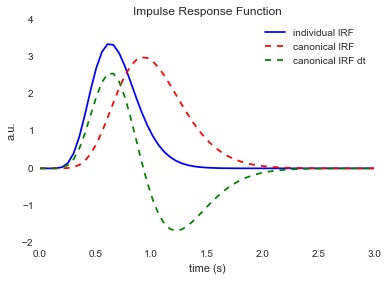

In [3]:
def pupil_IRF(timepoints, s=1.0/(10**26), n=10.1, tmax=0.93):
    
    """ pupil_IRF defines the IRF (response to a transient input) of the pupil.
    
    Parameters
    ----------
    timepoints: timepoints to evulate function
    s: scaling factor
    n: sets the width
    tmax: sets the time to peak 
    
    Returns
    -------
    y: IRF evaluated for 'timepoints'
    y_dt: IRF first derivative evaluated for 'timepoints'
    
    """
    
    # in sympy:
    t = sympy.Symbol('t')
    y = ( (s) * (t**n) * (math.e**((-n*t)/tmax)) )
    yprime = y.diff(t)
    
    # lambdify:
    y = sympy.lambdify(t, y, "numpy")
    y_dt = sympy.lambdify(t, yprime, "numpy")
    
    # evaluate:
    y = y(timepoints)
    y_dt = y_dt(timepoints)
    
    # normalize:
    y = y/np.std(y)
    y_dt = y_dt/np.std(y_dt)
    
    return (y, y_dt)


# create the IRF:
tmax_shifted = 0.93-0.3
sample_rate = 20
IRF_len = 3.0 # in seconds
timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)
IRF, IRF_prime = pupil_IRF(timepoints=timepoints)
IRF_shifted, IRF_prime_shifted = pupil_IRF(timepoints=timepoints, tmax=tmax_shifted)

# IRF_len = 20.0 # in seconds
# timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)
# IRF, IRF_prime = HRF(timepoints=timepoints)

# plot the IRF:
fig = plt.figure()
plt.plot(timepoints, IRF_shifted, color='b')
plt.plot(timepoints, IRF, color='r', ls='--')
plt.plot(timepoints, IRF_prime, color='g', ls='--')

plt.legend(['individual IRF', 'canonical IRF', 'canonical IRF dt',])
plt.title('Impulse Response Function')
plt.xlabel('time (s)')
plt.ylabel('a.u.')


Let's simulate convolved timeseries data based on this individual IRF.

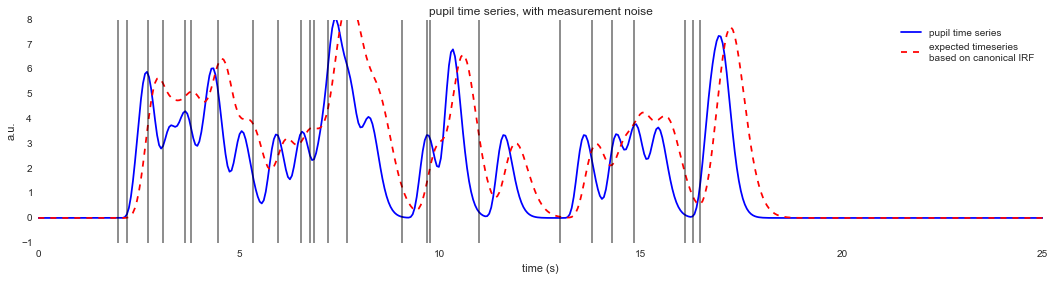

In [4]:
true_beta = 1
duration = 25 # in seconds
times = np.array([2,2.5,5,6,8.75,9,10,10.5,])
times = cumsum(exponential(1, duration))
times = times[times<duration]
input_signal = np.zeros(duration * sample_rate)
for i in times:
    input_signal[i*sample_rate] = true_beta

# convolve inputs with IRF:    
convolved_signal = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]
convolved_signal_shifted = (sp.convolve(input_signal, IRF_shifted, 'full'))[:-(IRF.shape[0]-1)]

# # let's add some noise:
# convolved_signal = convolved_signal + np.random.normal(0,0.2,len(convolved_signal))
# convolved_signal_shifted = convolved_signal_shifted + np.random.normal(0,0.2,len(convolved_signal_shifted))
    
# plot simulated convolved signal with noise:
timepoints = np.linspace(0,duration,duration*sample_rate)
fig = plt.figure(figsize=(18,4))
plt.plot(timepoints, convolved_signal_shifted, 'b')
plt.plot(timepoints, convolved_signal, 'r', ls='--')
plt.ylim(-1,8)
plt.legend(['pupil time series', 'expected timeseries\nbased on canonical IRF',], loc=1)
for i in times:
    plt.axvline(i, color='k', alpha=0.5)
plt.title('pupil time series, with measurement noise')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Let's create regressors (predictors) we want to put in our design matrix. Model 1 will be based on only the canonical IRF. Model 2 will be based on both the canonical IRF and it's temporal derivative.

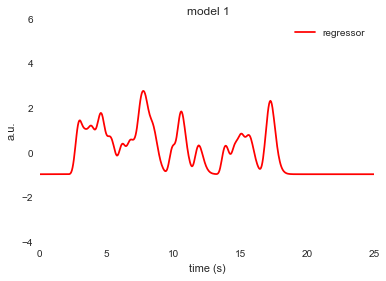

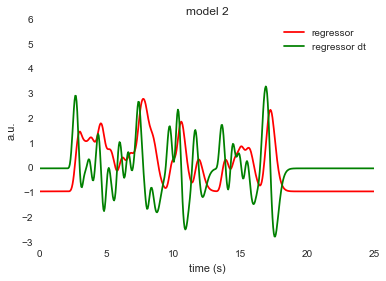

In [5]:
input_signal = np.zeros(duration * sample_rate)
for i in times:
    input_signal[i*sample_rate] = 1

# convolve inputs with IRF:    
regr_convolved = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]
regr_convolved_dt = (sp.convolve(input_signal, IRF_prime, 'full'))[:-(IRF_prime.shape[0]-1)]

# z-score measured data and regressors:
regr_convolved = (regr_convolved - regr_convolved.mean()) / regr_convolved.std()
regr_convolved_dt = (regr_convolved_dt - regr_convolved_dt.mean()) / regr_convolved_dt.std()
convolved_signal_shifted = (convolved_signal_shifted - convolved_signal_shifted.mean()) / convolved_signal_shifted.std()

fig = plt.figure()
plt.plot(timepoints, regr_convolved, 'r',)
plt.ylim(-4,6)
plt.legend(['regressor'], loc=1)
plt.title('model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure()
plt.plot(timepoints, regr_convolved, 'r',)
plt.plot(timepoints, regr_convolved_dt, 'g')
plt.ylim(-3,6)
plt.legend(['regressor', 'regressor dt'], loc=1)
plt.title('model 2')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

For every regressor (in the above model 2, we have two regressors, one based on the canonical IRF, and one based on it's temporal derivative) we want to find an associated scalar value (the "beta", $b$) that we can use to scale that particular regressor with, such that it best describes the measured timeseries.

In the GLM, with a procedure called "multiple regression" we look for betas that minimimize the sum of squares of errors across all $k$ regressors in our design matrix at the same time.

To do so, we set up the following equation (for a derivation, see all the way below):

$ b = (X'X)^{-1} X'y $

In which,

$b$ is a vector containing the betas (size: number of regressors; in the above toy example: 2);

$X$ is the design matrix (size: length BOLD time series x number of regressors);

$y$ is the measured timeseries.

Indeed, with model 2 we find a beta of about 1. This is what we used as input to simulate the "measured timeseries". So this works!! 

Let's plot our explained signal. We construct this by multiplying our regessors with their respective betas, and add them all up:

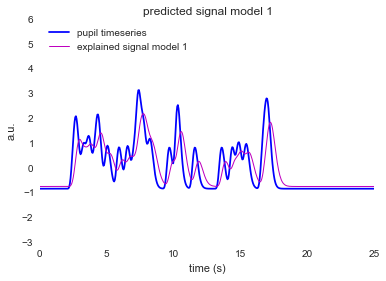

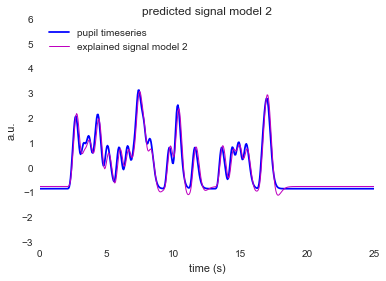

In [7]:
# plotting:
fig = plt.figure()
plt.plot(timepoints, convolved_signal_shifted, 'b')
plt.ylim(-3,6)
plt.plot(timepoints, explained_signal_0, 'm', lw=1)
plt.legend(['pupil timeseries', 'explained signal model 1'], loc=2)
plt.title('predicted signal model 1')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

fig = plt.figure()
plt.plot(timepoints, convolved_signal_shifted, 'b')
plt.plot(timepoints, explained_signal_1, 'm', lw=1)
plt.ylim(-3,6)
plt.legend(['pupil timeseries', 'explained signal model 2'], loc=2)
plt.title('predicted signal model 2')
plt.xlabel('time (s)')
plt.ylabel('a.u.')


#### The spline model
I'll start by making a basis set of 1D splines. These are orthogonal to each other and form a proper basis function that is completely contained in a finite interval (unlike e.g. a Gaussian basis set)

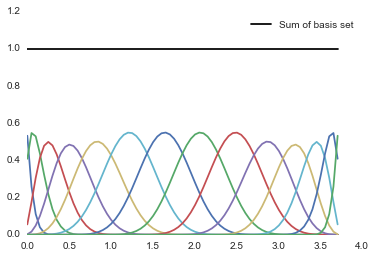

In [20]:
from ocupy import spline_base
dt = unique(diff(timepoints))[0]
length = 75
basis, knots = spline_base.spline_base1d(75, 10)
for base in basis.T:
    plot(dt*arange(length), base)
l = plot(dt*arange(length), basis.sum(1), 'k')[0]
legend([l], ['Sum of basis set'])

Now I create a design matrix where the event onsets are convolved with each basis function.

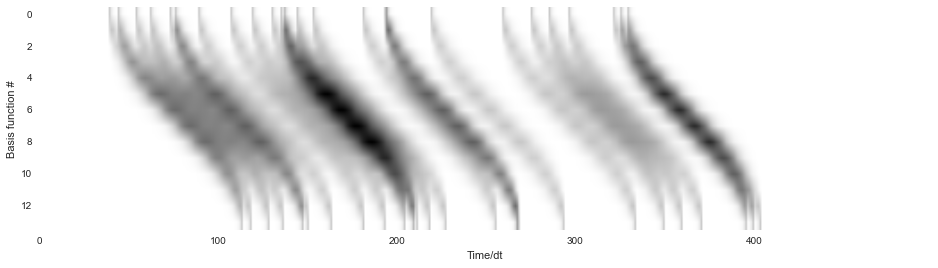

In [32]:
predictor = 0*ones(convolved_signal_shifted.shape)
idx = [argmin(abs(timepoints-t)) for t in times]
predictor[idx] = 1
design = []
figure(figsize=(16,4))
for base in basis.T:
    pc = (sp.convolve(predictor, base, 'full'))[:-(base.shape[0]-1)]
    #convolve(predictor, base, 'same')
    design.append(pc)
design = vstack(design).T
imshow(design.T, aspect='auto')
grid('off')
xlabel('Time/dt')
ylabel('Basis function #')

Now we can fit the linear model and plot the fitted IRF. The shape matches really nicely, but I don't know why the amplitude doesn't match. But the linear model yields pretty much exactly the same prediction as JW's previous individual model. So it is able to account for these differences.

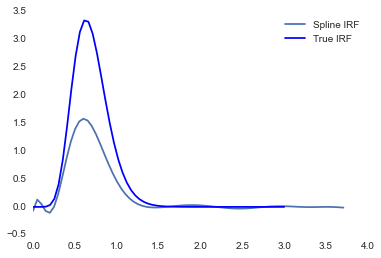

In [35]:
import statsmodels.api as sm
design_wi = sm.add_constant(design)
model = sm.OLS(convolved_signal_shifted, design_wi)
results = model.fit()
sIRF = (basis*results.params[1:]).sum(1)
plot(dt*arange(length), sIRF)
timepoints_IRF = np.linspace(0,IRF_len,IRF_len*sample_rate)
plt.plot(timepoints_IRF, IRF_shifted, color='b')
legend(['Spline IRF', 'True IRF'])

Now you might say that having all these extra parameters is really nasty - and I agree. But you can use this procedure to estimate the IRF and then fit a new linear model that only uses the estimated IRF and the results will be the same. This way you get rid of these extra parameters.

In [16]:
# make design matrix:
designMatrix_0 = np.mat(regr_convolved).T
designMatrix_1 = np.mat(np.vstack((regr_convolved, regr_convolved_dt))).T

# multiple regression, yielding the betas:
betas_0 = np.array(((designMatrix_0.T * designMatrix_0).I * designMatrix_0.T) * np.mat(convolved_signal_shifted).T).ravel()
betas_1 = np.array(((designMatrix_1.T * designMatrix_1).I * designMatrix_1.T) * np.mat(convolved_signal_shifted).T).ravel()
betas_1_combined = np.sign(betas_1[::2])*np.sqrt((betas_1[::2]**2) + (betas_1[1::2]**2))

# explained signal:
explained_signal_0 = regr_convolved*betas_0[0]
explained_signal_1 = regr_convolved*betas_1[0] + regr_convolved_dt*betas_1[1]

# model fit:
r_0, p_0 = sp.stats.pearsonr(convolved_signal_shifted, explained_signal_0)
r_1, p_1 = sp.stats.pearsonr(convolved_signal_shifted, explained_signal_1)

print 'model 0:'
print '---------'
print 'beta: {}\nR2: {}'.format(round(betas_0,3), round(r_0,3))
print
print 'model 1:'
print '---------'
print 'beta: {} ({} ; {})\nR2: {}'.format(round(betas_1_combined,3), round(betas_1[0],3), round(betas_1[1],3), round(r_1,3))
print
print 'Spline model:'
print '-------------'
print 'R-squared:', results.rsquared
print
print '---------'
print 'true beta: {}'.format(true_beta)
print '---------'
print

model 0:
---------
beta: 0.787
R2: 0.787

model 1:
---------
beta: 0.976 (0.787 ; 0.577)
R2: 0.976

Spline model:
-------------
R-squared: 0.991015348752

---------
true beta: 1
---------



Let's also plot our residual error, the part of the signal that we were not able to explain. We construct this my subtracting our explained signal from the measured timeseries. Note that this should look like random (white) noise. If not, then there is still some components in the signal that we failed to explain. 

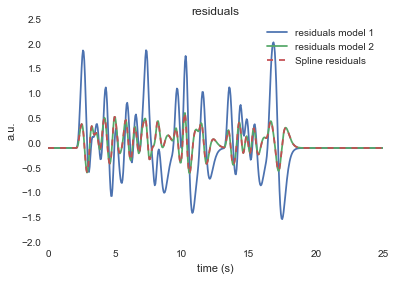

In [47]:
# residuals:
residuals_0 = convolved_signal_shifted - explained_signal_0
residuals_1 = convolved_signal_shifted - explained_signal_1
residuals_2 = convolved_signal_shifted - results.fittedvalues

fig = plt.figure()
plt.plot(timepoints, residuals_0)
plt.plot(timepoints, residuals_1)
plt.plot(timepoints, residuals_1, '--')


plt.legend(['residuals model 1', 'residuals model 2', 'Spline residuals'], loc=1)
plt.title('residuals')
plt.xlabel('time (s)')
plt.ylabel('a.u.')
